In [3]:
import pandas as pd
import random
import gensim
from gensim.utils import simple_preprocess
from time import time

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [4]:
words_list = pd.read_csv('korean_wordlist.csv')

In [5]:
words_list

,English,Korean
0,apple,sagwa
1,apricot,salgu
2,avocado,abokado
3,banana,banana
4,blackberry,beulraek beri
...,...,...
754,uranus,cheonwangseong
755,neptune,haewangseong
756,mercury,sueun
757,jupiter,mokseong


In [6]:
wiki = pd.read_csv('wikipedia_sentences_2.csv')


In [43]:
#convert sentences into a list
sentences_list = wiki.iloc[:, 0].tolist()
print(f"totla number of sentences {len(sentences_list)}")


#from gensim library, it tokenizes (splits input into words on spaces), converts all words to lowercase, and removes words with less than 2 letters or more than 15 letters.
clean_sentences = [simple_preprocess(sentence) for sentence in sentences_list]

totla number of sentences 40543


In [44]:
# removing stop words
stop_words = [
    "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "aren't", "as", "at", "be", "because", "been", "before",
    "being", "below", "between", "both", "but", "by", "can't", "cannot","could", "couldn't", "did", "didn't", "do", "does", "doesn't", "doing",
    "don't", "down", "during", "each", "few", "for", "from", "further", "had","hadn't", "has", "hasn't", "have", "haven't", "having", "he", "he'd",
    "he'll", "he's", "her", "here", "here's", "hers", "herself", "him","himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if",
    "in", "into", "is", "isn't", "it", "it's", "its", "itself", "let's", "me", "more", "most", "mustn't", "my", "myself", "no", "nor", "not", "of", "off",
    "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves","out", "over", "own", "same", "shan't", "she", "she'd", "she'll", "she's",
    "should", "shouldn't", "so", "some", "such", "than", "that", "that's","the", "their", "theirs", "them", "themselves", "then", "there",
    "there's", "these", "they", "they'd", "they'll", "they're", "they've","this", "those", "through", "to", "too", "under", "until", "up", "very",
    "was", "wasn't", "we", "we'd", "we'll", "we're", "we've", "were","weren't", "what", "what's", "when", "when's", "where", "where's",
    "which", "while", "who", "who's", "whom", "why", "why's", "with","won't", "would", "wouldn't", "you", "you'd", "you'll", "you're",
    "you've", "your", "yours", "yourself", "yourselves"
]

for sentence in clean_sentences:
    sentence[:] = [word for word in sentence if word not in stop_words]




In [45]:
#testing for Lemmatization reduces words to their base form (e.g., "apples" → "apple", "berries" → "berry").
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

clean_sentences = [
    [lemmatizer.lemmatize(word) for word in simple_preprocess(sentence) if word not in stop_words]
    for sentence in sentences_list
]

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/arashheidari/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [46]:
random.seed(42)
np.random.seed(42)
#word2vec model from gensim library
model = gensim.models.Word2Vec(
    window=5,
    min_count=7,
    workers=1,
    vector_size=120,
    seed=42,
)

#bulding one-hot-encoding of our words
model.build_vocab(clean_sentences, progress_per=10)


print(f"number of words in our datasets {len(model.wv)}")


number of words in our datasets 10135


In [47]:
t = time()

#training the model
model.train(clean_sentences, total_examples=model.corpus_count, epochs=30)


print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

print("model was trained over sentences succesfully")


Time to train the model: 0.33 mins
model was trained over sentences succesfully


In [26]:
print(model.wv.most_similar("apple", topn=10))

[('fig', 0.5920807719230652), ('fruit', 0.585195004940033), ('cider', 0.5834290981292725), ('pear', 0.5769485831260681), ('avocado', 0.5749404430389404), ('lychee', 0.5501925945281982), ('ripen', 0.5476750135421753), ('grape', 0.545891523361206), ('cultivar', 0.5310326218605042), ('sour', 0.5243748426437378)]


In [27]:
print(model.wv.most_similar("compost", topn=10))

[('composted', 0.6641448140144348), ('fertilizer', 0.6635199189186096), ('aerated', 0.6353595852851868), ('wastewater', 0.5898892283439636), ('extract', 0.5663503408432007), ('fermented', 0.5596444010734558), ('gardener', 0.549828827381134), ('preservative', 0.5446310639381409), ('soybean', 0.5416779518127441), ('vegetable', 0.5405073165893555)]


In [28]:
print(model.wv.most_similar("football", topn=1))

[('rugby', 0.7294186353683472)]


In [29]:
model.wv.most_similar(positive=["apple", "fish"], negative=["cat"], topn=3)

[('grape', 0.44366225600242615),
 ('nut', 0.4388984441757202),
 ('fruit', 0.4268338084220886)]

In [444]:
round(model.wv.similarity('apple','banana'),3)

0.349

In [445]:
model.wv.__getitem__(["cat"]).shape

(1, 300)

In [31]:
 def plot_words(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 120), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=21).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-10, Y[:, 0].max()+10)
    plt.ylim(Y[:, 1].min()-10, Y[:, 1].max()+10)
            
    plt.title('10 most similar word for {} vs 10 most dissimilar'.format(word.title()))

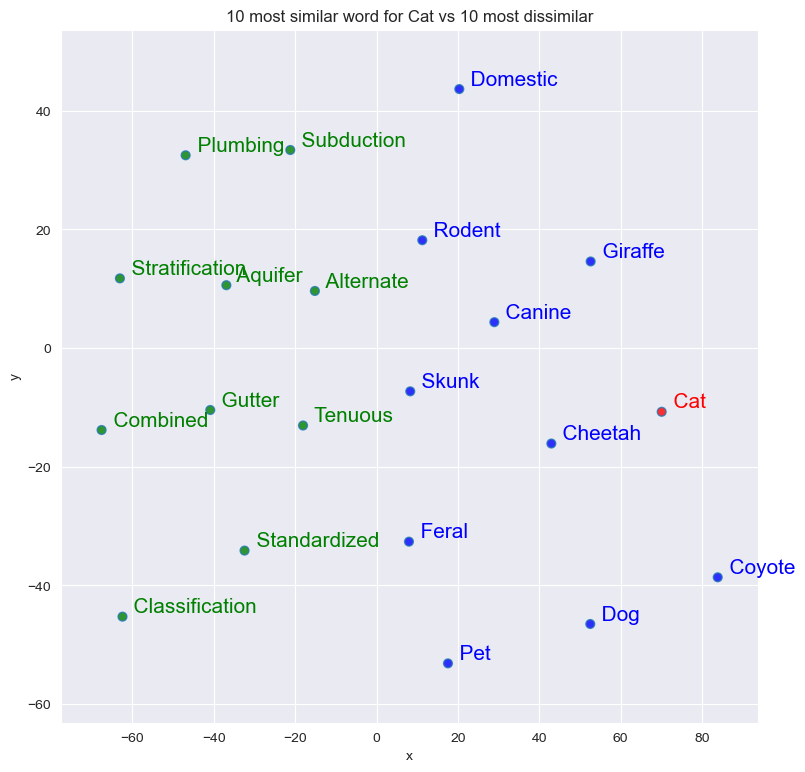

In [32]:
plot_words(model,"cat",[i[0] for i in model.wv.most_similar(negative=["cat"])])

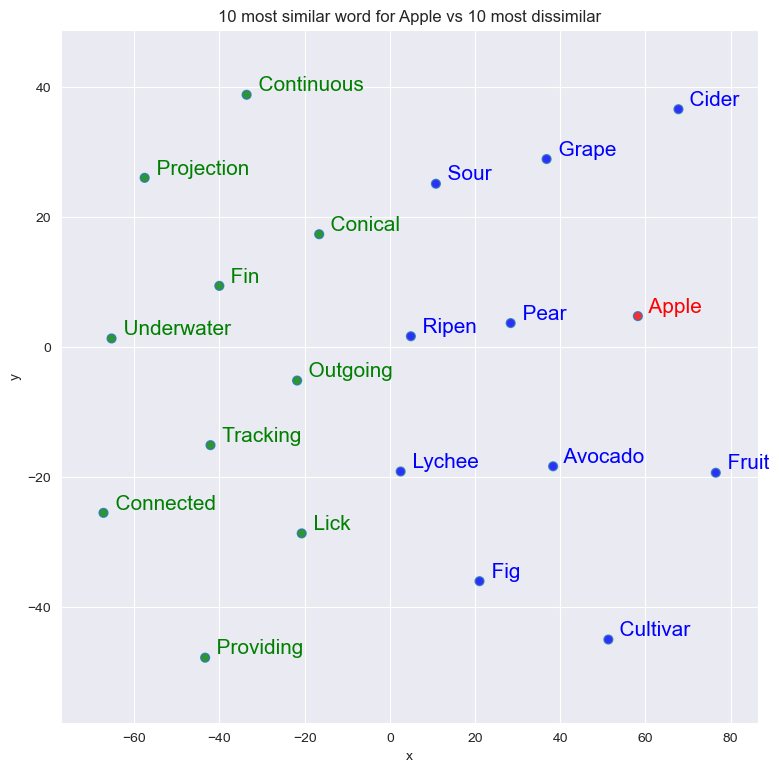

In [34]:
plot_words(model,"apple",[i[0] for i in model.wv.most_similar(negative=["apple"])])

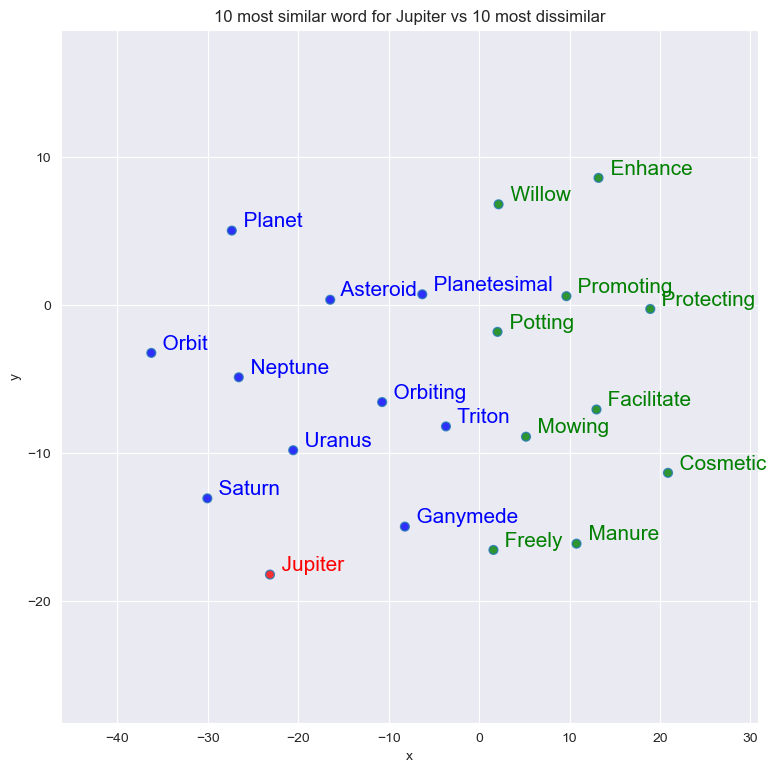

In [35]:
plot_words(model,"jupiter",[i[0] for i in model.wv.most_similar(negative=["jupiter"])])

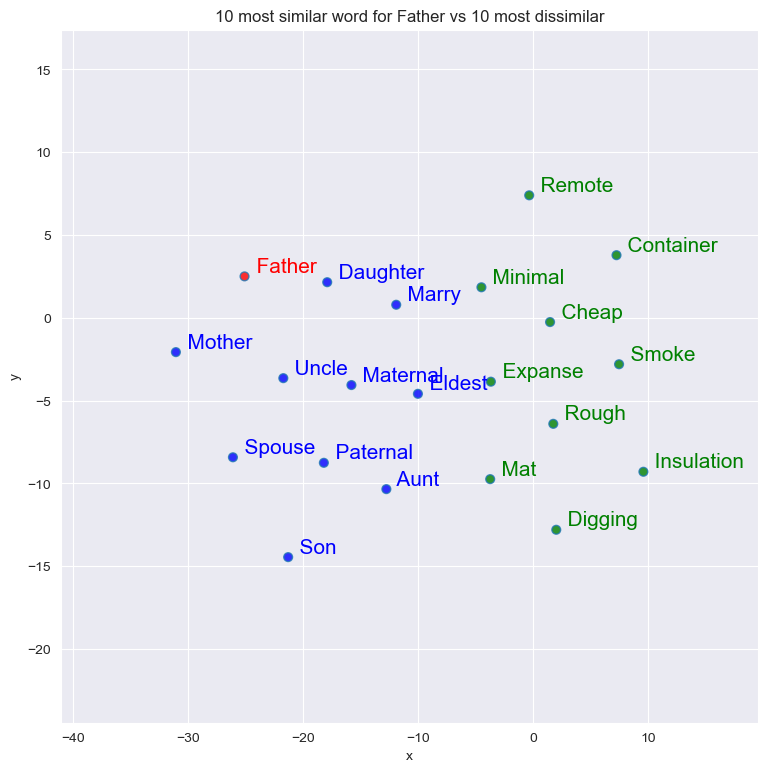

In [36]:
plot_words(model,"father",[i[0] for i in model.wv.most_similar(negative=["father"])])

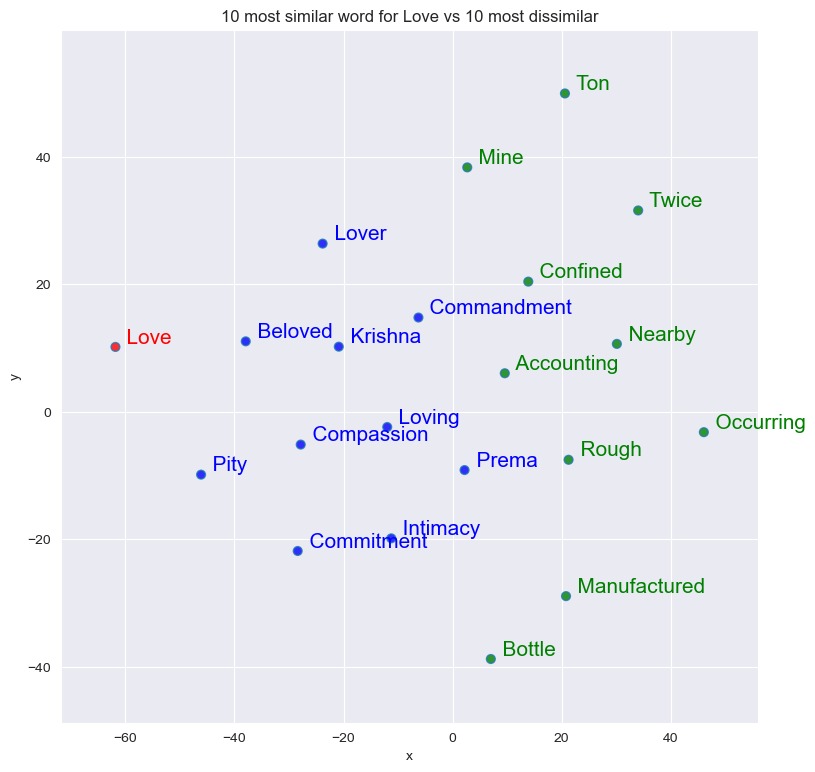

In [37]:
plot_words(model,"love",[i[0] for i in model.wv.most_similar(negative=["love"])])

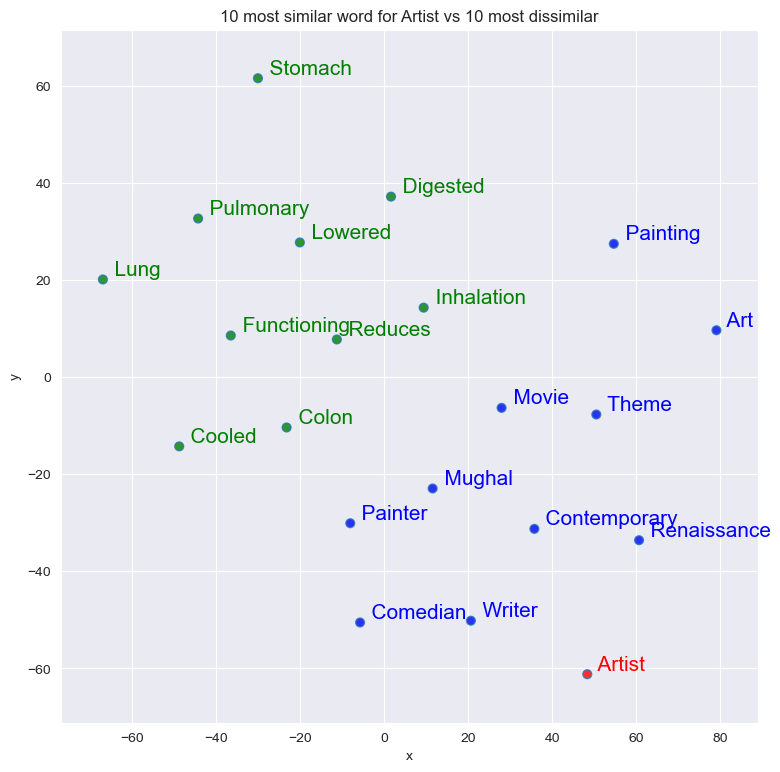

In [38]:
plot_words(model,"artist",[i[0] for i in model.wv.most_similar(negative=["artist"])])

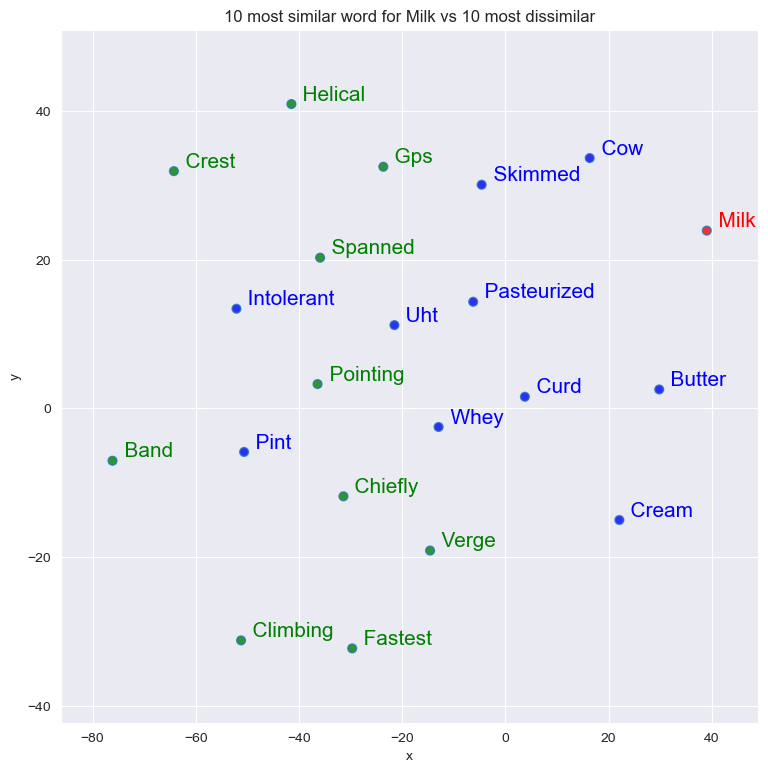

In [39]:
plot_words(model,"milk",[i[0] for i in model.wv.most_similar(negative=["milk"])])

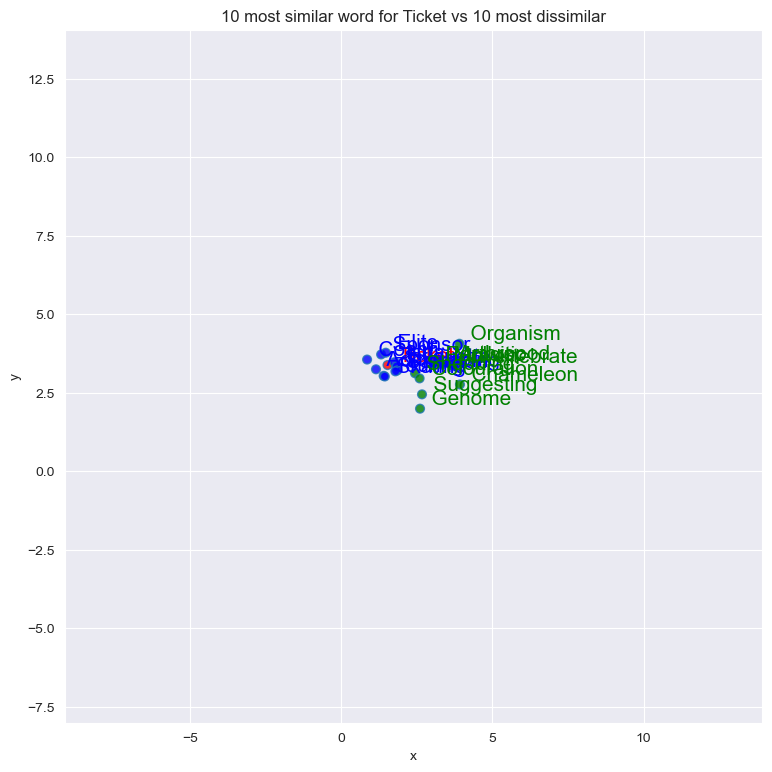

In [40]:
plot_words(model,"ticket",[i[0] for i in model.wv.most_similar(negative=["ticket"])])

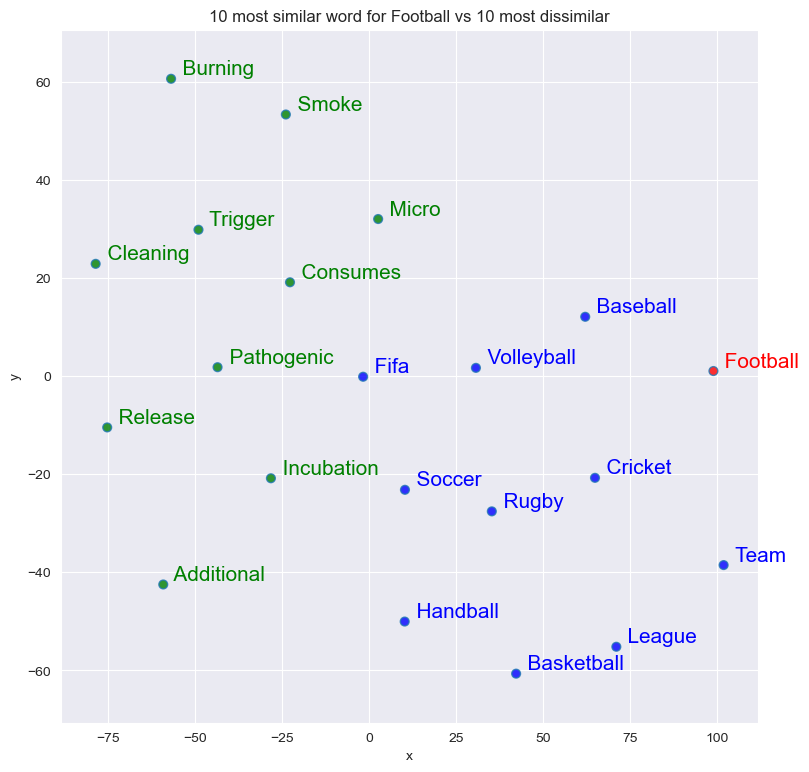

In [42]:
plot_words(model,"football",[i[0] for i in model.wv.most_similar(negative=["football"])])

In [ ]:
word_list = ['apple', 'apricot', 'avocado', 'banana', 'blackberry', 'blueberry', 'cherry', 'cloudberry', 'coconut', 'cranberry', 'cucumber', 'date', 'dragonfruit', 'fig', 'grape', 'grapefruit', 'guava', 'kiwifruit', 'lemon', 'lime', 'lychee', 'mango', 'melon', 'cantaloupe', 'honeydew', 'watermelon', 'nectarine', 'olive', 'orange', 'clementine', 'tangerine', 'papaya', 'passionfruit', 'peach', 'pear', 'persimmon', 'plum', 'prune', 'pineapple', 'pomegranate', 'quince', 'raspberry', 'strawberry', 'aardvark', 'alligator', 'antelope', 'armadillo', 'baboon', 'badger', 'bat', 'bear', 'beaver', 'bison', 'bull', 'camel', 'chameleon', 'cheetah', 'chihuahua', 'chimpanzee', 'chipmunk', 'coyote', 'crocodile', 'deer', 'dinosaur', 'donkey', 'eagle', 'eel', 'elephant', 'penguin', 'falcon', 'giraffe', 'goose', 'guinea pig', 'hare', 'hawk', 'hedgehog', 'hippopotamus', 'horse', 'hyena', 'iguana', 'dog', 'jackal', 'jaguar', 'jellyfish', 'kangaroo', 'koala', 'leopard', 'lion', 'meerkat', 'mole', 'mongoose', 'lizard', 'monkey', 'moose', 'orangutan', 'otter', 'owl', 'panda', 'panther', 'porcupine', 'possum', 'puma', 'rabbit', 'raccoon', 'reindeer', 'rhinoceros', 'seal', 'sheep', 'skunk', 'squirrel', 'tiger', 'walrus', 'boar', 'cat', 'wolf', 'zebra', 'tree', 'forest', 'river', 'ocean', 'mountain', 'hill', 'valley', 'lake', 'stream', 'beach', 'desert', 'jungle', 'meadow', 'flower', 'grass', 'leaf', 'cave', 'cliff', 'canyon', 'field', 'tundra', 'geyser', 'lagoon', 'bay', 'gulf', 'island', 'peninsula', 'wildlife', 'organic', 'climate', 'weather', 'season', 'spring', 'summer', 'autumn', 'winter', 'nature', 'earth', 'planet', 'solar', 'lunar', 'atmosphere', 'hail', 'storm', 'thunder', 'lightning', 'cloud', 'sun', 'moon', 'star', 'sky', 'wind', 'breeze', 'hurricane', 'tornado', 'volcano', 'earthquake', 'plant', 'bush', 'vine', 'reptile', 'mammal', 'ecosystem', 'habitat', 'animal', 'bird', 'fish', 'insect', 'environment', 'pollution', 'recycle', 'compost', 'soil', 'greenhouse', 'swamp', 'rain', 'sand', 'rock', 'stone', 'pebble', 'conservation', 'tsunami', 'glacier', 'iceberg', 'coral', 'waterfall', 'pond', 'marsh', 'snow', 'atlantic', 'tropical', 'cauliflower', 'spinach', 'chives', 'onion', 'radish', 'potato', 'eggplant', 'chickpeas', 'beans', 'cabbage', 'celery', 'basil', 'mushrooms', 'garlic', 'bell pepper', 'peanuts', 'peas', 'lavender', 'pepper', 'ginger', 'yam', 'kale', 'jalapeno', 'beetroot', 'spaghetti', 'tomato', 'broccoli', 'mustard', 'lettuce', 'carrot', 'pumpkin', 'forearm', 'arm', 'corpse', 'brain', 'elbow', 'heart', 'skull', 'neck', 'body', 'finger', 'toe', 'tooth', 'skeleton', 'eyeball', 'shoulder', 'bone', 'earlobe', 'chin', 'muscle', 'thigh', 'knuckle', 'eye', 'eyelid', 'chest', 'hair', 'foot', 'thumb', 'armpit', 'heel', 'tendon', 'eardrum', 'ankle', 'torso', 'abdomen', 'stomach', 'artery', 'beard', 'belly', 'mouth', 'head', 'hip', 'face', 'eyebrow', 'waist', 'spine', 'back', 'shin', 'forehead', 'throat', 'fingerprint', 'groin', 'teardrop', 'tongue', 'jaw', 'hand', 'cheek', 'mind', 'wrist', 'nose', 'ear', 'palm', 'calf', 'eyelash', 'skin', 'leg', 'sole', 'knee', 'kneecap', 'temple', 'fingernail', 'toenail', 'vein', 'nostril', 'whiskers', 'biceps', 'teeth', 'intestines', 'lips', 'grandmother', 'grandma', 'grandpa', 'grandfather', 'grandparents', 'wedding', 'friend', 'wife', 'family', 'sister', 'step-brother', 'brother', 'siblings', 'daughter', 'son', 'orphan', 'stepmother', 'mother', 'godmother', 'husband', 'twin', 'granddaughter', 'grandson', 'bride', 'groom', 'stepfather', 'fiance', 'girlfriend', 'boyfriend', 'father', 'parents', 'godfather', 'godparents', 'relatives', 'cousin', 'niece', 'nephew', 'mother-in-law', 'father-in-law', 'aunt', 'uncle', 'neighbors', 'widow', 'widower', 'son-in-law', 'daughter-in-law', 'padlock', 'deck', 'shower', 'closet', 'attic', 'bathroom', 'mailbox', 'road', 'ceiling', 'bedroom', 'fireplace', 'furnace', 'garden', 'yard', 'hallway', 'playground', 'floor', 'porch', 'basement', 'shed', 'roof', 'doorbell', 'cabinet', 'carpet', 'sidewalk', 'library', 'pantry', 'street', 'alley', 'driveway', 'highway', 'house', 'lock', 'chimney', 'kitchen', 'address', 'key', 'light', 'doorknob', 'door', 'gate', 'living room', 'family room', 'fence', 'window', 'curtains', 'stairs', 'flowers', 'rocks', 'steps', 'furniture', 'patio', 'laundry room', 'computer', 'mouse', 'keyboard', 'monitor', 'smartphone', 'tablet', 'television', 'remote', 'chair', 'table', 'desk', 'lamp', 'book', 'pen', 'pencil', 'notebook', 'wallet', 'keys', 'watch', 'glasses', 'cup', 'plate', 'fork', 'spoon', 'knife', 'refrigerator', 'oven', 'microwave', 'toaster', 'sofa', 'bed', 'pillow', 'blanket', 'car', 'bicycle', 'truck', 'motorcycle', 'bus', 'van', 'suv', 'sedan', 'convertible', 'pickup', 'minivan', 'tractor', 'trailer', 'engine', 'brake', 'oil', 'battery', 'blouse', 'shirt', 'jeans', 'pants', 'shorts', 'skirt', 'dress', 'jacket', 'coat', 'sweater', 'hoodie', 'cardigan', 'suit', 'tie', 'belt', 'socks', 'pajamas', 'robe', 'hat', 'cap', 'scarf', 'gloves', 'boots', 'sneakers', 'bomber', 'trench', 'windbreaker', 'vest', 'denim', 'cotton', 'silk', 'wool', 'linen', 'polyester', 'velvet', 'satin', 'lace', 'backpack', 'headphones', 'charger', 'umbrella', 'sunglasses', 'shoes', 'camera', 'flashlight', 'scissors', 'glue', 'ruler', 'calendar', 'clock', 'mirror', 'soap', 'toothbrush', 'toothpaste', 'towel', 'ball', 'game', 'instrument', 'hammer', 'screwdriver', 'paintbrush', 'feather', 'shell', 'coin', 'stamp', 'ticket', 'recipe', 'map', 'letter', 'photograph', 'painting', 'sculpture', 'tool', 'ingredient', 'spice', 'fabric', 'thread', 'button', 'needle', 'puzzle', 'dice', 'flour', 'yeast', 'dough', 'batter', 'sourdough', 'gluten', 'bread', 'cake', 'cookies', 'muffins', 'pies', 'biscuits', 'pastry', 'crust', 'whisk', 'spatula', 'kneading', 'fermentation', 'sugar', 'salt', 'butter', 'milk', 'egg', 'vanilla', 'cinnamon', 'icing', 'frosting', 'pan', 'action', 'adventure', 'comedy', 'drama', 'fantasy', 'horror', 'mystery', 'romance', 'thriller', 'western', 'documentary', 'animation', 'musical', 'crime', 'historical', 'biographical', 'war', 'experimental', 'superhero', 'cyberpunk', 'dystopian', 'satire', 'parody', 'soccer', 'basketball', 'baseball', 'football', 'tennis', 'cricket', 'volleyball', 'rugby', 'golf', 'swimming', 'track', 'gymnastics', 'boxing', 'wrestling', 'cycling', 'hockey', 'skiing', 'snowboarding', 'surfing', 'skateboarding', 'running', 'marathon', 'sprint', 'relay', 'judo', 'karate', 'fencing', 'archery', 'badminton', 'table tennis', 'lacrosse', 'polo', 'bowling', 'triathlon', 'rowing', 'sailing', 'canoeing', 'kayaking', 'weightlifting', 'esports', 'kickboxing', 'frisbee', 'softball', 'handball', 'dodgeball', 'biking', 'boat', 'ambulance', 'helicopter', 'tricycle', 'stroller', 'skateboard', 'train', 'airplane', 'taxi', 'snowmobile', 'teacher', 'doctor', 'astronaut', 'zookeeper', 'nurse', 'chef', 'lawyer', 'plumber', 'artist', 'athlete', 'janitor', 'psychologist', 'mailman', 'politician', 'singer', 'happy', 'sad', 'scared', 'envy', 'pity', 'frustration', 'disgust', 'angry', 'love', 'surprise', 'annoyance', 'excitement', 'cautious', 'shy', 'worried', 'confused', 'tea', 'water', 'juice', 'coffee', 'punch', 'hot chocolate', 'cider', 'soda', 'new year', 'halloween', 'independence day', 'labor day', 'veterans day', 'thanksgiving', 'christmas', 'buffalo', 'capital', 'card', 'casino', 'church', 'circle', 'club', 'concert', 'conductor', 'contract', 'copper', 'court', 'crown', 'cycle', 'dance', 'day', 'diamond', 'dragon', 'fire', 'flute', 'ghost', 'glass', 'glove', 'gold', 'hospital', 'hotel', 'ice', 'iron', 'ivory', 'kid', 'king', 'night', 'novel', 'red', 'blue', 'yellow', 'purple', 'pink', 'brown', 'black', 'white', 'green', 'gray', 'square', 'triangle', 'rectangle', 'oval', 'cube', 'pyramid', 'cylinder', 'conic', 'sphere', 'venus', 'mars', 'saturn', 'uranus', 'neptune', 'mercury', 'jupiter', 'pluto']

In [ ]:
def find_highest_lowest_score(model,word_list):
    highest = float('-inf')
    lowest = float('inf')
    for wrd in word_list:
        